Importing necessary modules and packages

In [118]:
import numpy as np
import pickle
import bilby
from pesummary.io import read
import pandas as pd
import scipy as sp
pd.options.display.max_columns = None
from qmwaves.utils import FindImportantIndices, gen_td_waveform, create_asd_dic_for_whiten, get_tukey_window
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve

loading posterios sample file and sorting them based on loglikelihood values

In [119]:
posdata = read("posterior_samples.h5", disable_remnant=True)
samples = posdata.samples_dict["bilby"]
df = pd.DataFrame.from_dict(samples)
df_400 = df[:400]
df_1 = df[:1]
samples_400 = df_400.to_dict(orient='list')
samples_1 = df_1.to_dict(orient='list')

assigning all default values

In [120]:
flow = 20
fref = 20
fhigh = 1024
deltaT = 0.5/fhigh
event_time = samples['geocent_time'][0]
strain_end_time = round(samples['geocent_time'][0]) + 2
approx = 'IMRPhenomPv2'
req_dur = 2

loading template_data and time_data and PSD data

In [121]:
psd_data_h1 = np.loadtxt('psds/GWTC1_GW150914_H1_1.txt')
temp_h1 = np.load('Test/IMRPhenomXHM/onsource_overlap/tmp_data_H1_0_400.npy')
temp_h1_1 = temp_h1[0]
time_h1 = np.load('Test/IMRPhenomXHM/onsource_overlap/H1times.npy')

psd_data_l1 = np.loadtxt('psds/GWTC1_GW150914_L1_1.txt')
temp_l1 = np.load('Test/IMRPhenomXHM/onsource_overlap/tmp_data_L1_0_400.npy')
temp_l1_1 = temp_h1[0]
time_l1 = np.load('Test/IMRPhenomXHM/onsource_overlap/L1times.npy')

overlaping whitened get_td_waveform data with whitened o/p template data

In [122]:
#getting the asd_whiten values to whiten the waveform data
delta_f, freqsArr, asd_whiten = create_asd_dic_for_whiten(psd_data_h1, flow, fhigh, req_dur=2)

#generating waveform from the posterior values using get_td_waveform funciton (with whitening flag = True)
det_strain_h1 = gen_td_waveform(samples_1, deltaT, delta_f, flow, approx, \
                f_ref = fref, det='H1', ind=0, asd_whiten = asd_whiten, \
                whiten=True, strain_end_time = strain_end_time, millilens_type=None, LIVFlag=False)

0.5


Overlap plotting the gen_td_waveform over the template data (both whitened)

(1126259461.9140625, 1126259462.7135742)

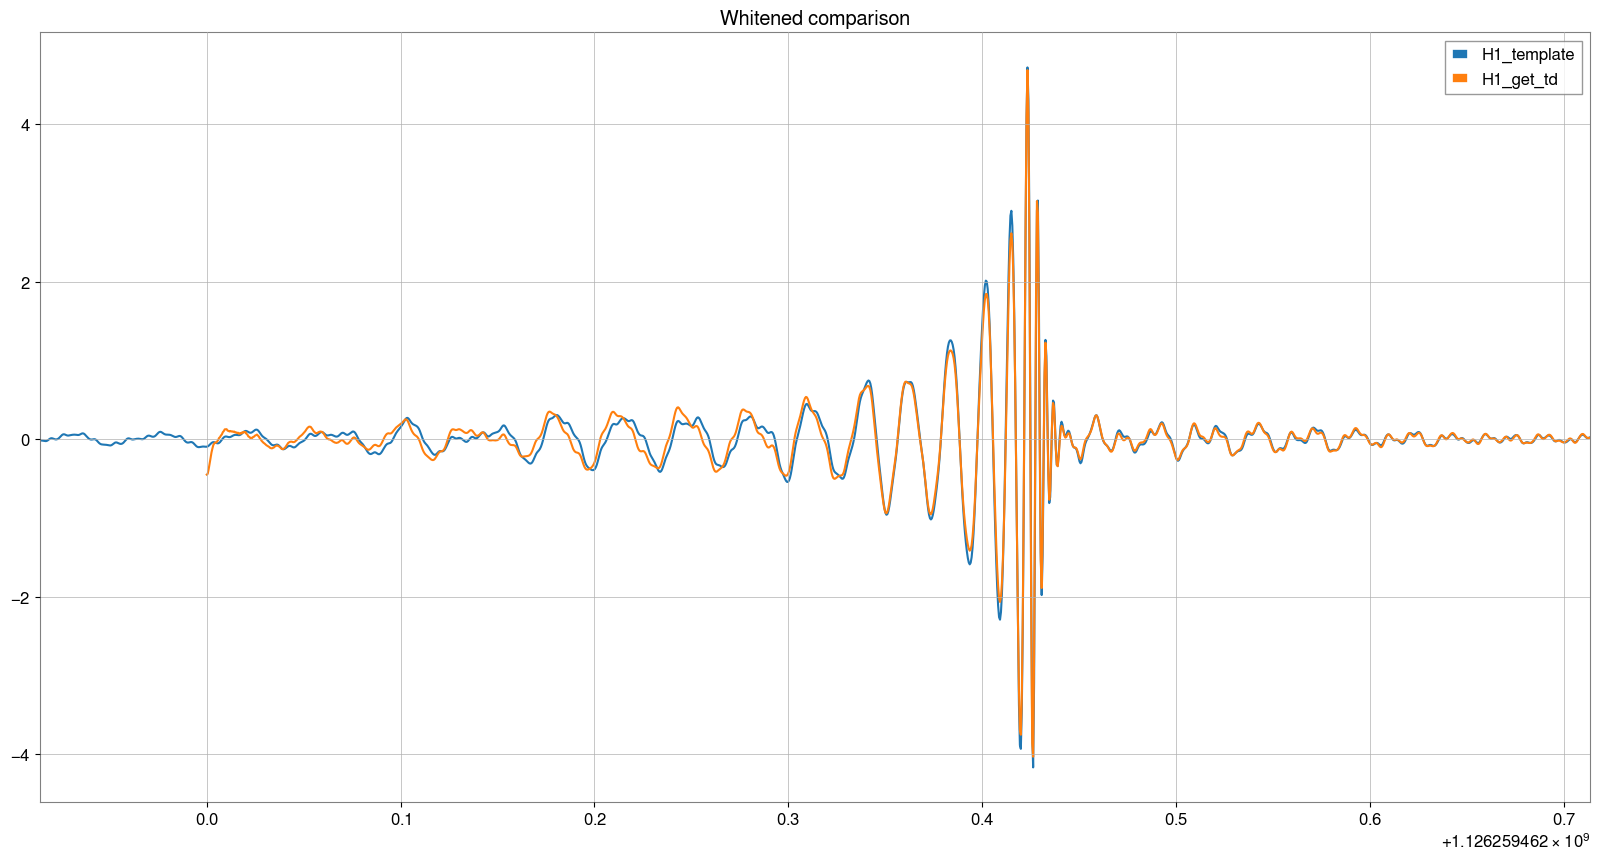

In [123]:
plt.figure(figsize=(20,10))
plt.plot(time_h1, temp_h1_1, label = 'H1_template')
plt.plot(det_strain_h1, label='H1_get_td')
plt.title('Whitened comparison')
plt.legend()
plt.xlim(time_h1.min()+1,time_h1.max()-0.2)

overlaping unwhitened get_td_waveform data with unwhitened o/p template data <br>
Step 1: unwhiten the o/p template data<br>
Step 2: set whiten=False in get_td_waveform and get the datat<br>
Step 3: Overlap plot the two datas.

Step 1: Unwhitening the o/p template data

In [124]:
#Function to obatin the unwhitening factor
def create_asd_for_unwhiten(psd_data, flow, fhigh, req_dur):
    freqs, psd = psd_data[:,0], psd_data[:,1]

    delta_f = 1.0/req_dur

    freqsArr = np.arange(0.0, fhigh+delta_f, delta_f)
    deltaT = 0.5/fhigh
    
    psd_interp = sp.interpolate.interp1d(freqs, psd, bounds_error=False, fill_value=0)
    PSD = psd_interp(freqsArr)
    
    ASD = PSD**0.5
    ASD[ : int(flow/delta_f) ] = 0
    asd_unwhiten = ASD*np.sqrt(1.0/deltaT/2)
    plt.figure(figsize=(20,10))
    plt.loglog(freqsArr,asd_unwhiten)
    plt.xlabel("freqsArr")
    plt.ylabel("asd_unwhiten")
    plt.title('freqsArr vs asd_unwhiten')
    return delta_f,freqsArr,asd_unwhiten

#Function to unwhiten the data
def unwhitening(sig, psd, time, str):
    delta_f, freqsArr, asd_unwhiten_h1 = create_asd_for_unwhiten(psd, flow, fhigh, req_dur=2)
    unwhiten_dat = []
    window = get_tukey_window(len(sig), beta=0.05, start=True, end=True)
    #hf = np.fft.rfft(sig)  #without tukeywindow
    hf = np.fft.rfft(sig*window) #with tukeywindow
    unwhiten_hf = hf * asd_unwhiten_h1
    strain = np.fft.irfft(unwhiten_hf , n=len(sig))
    unwhiten_dat = np.array(strain)

    #plotting code
    figure, axis = plt.subplots(3, 1, figsize=(20, 20))
    axis[0].plot(time, sig)
    axis[0].set_title(str+" Time series - before rrft")
    axis[0].set_xlabel('time')
    
    axis[1].plot(freqsArr, hf)
    axis[1].set_title(str+" Frequency series - after rrft / before irrft") 
    axis[1].set_xlabel('Frequency')
    
    axis[2].plot(time, strain) 
    axis[2].set_title(str+" Time series - after irrft")     
    axis[2].set_xlabel('time')
    
    return unwhiten_dat

/home/rahule/anaconda3/envs/gw_env/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


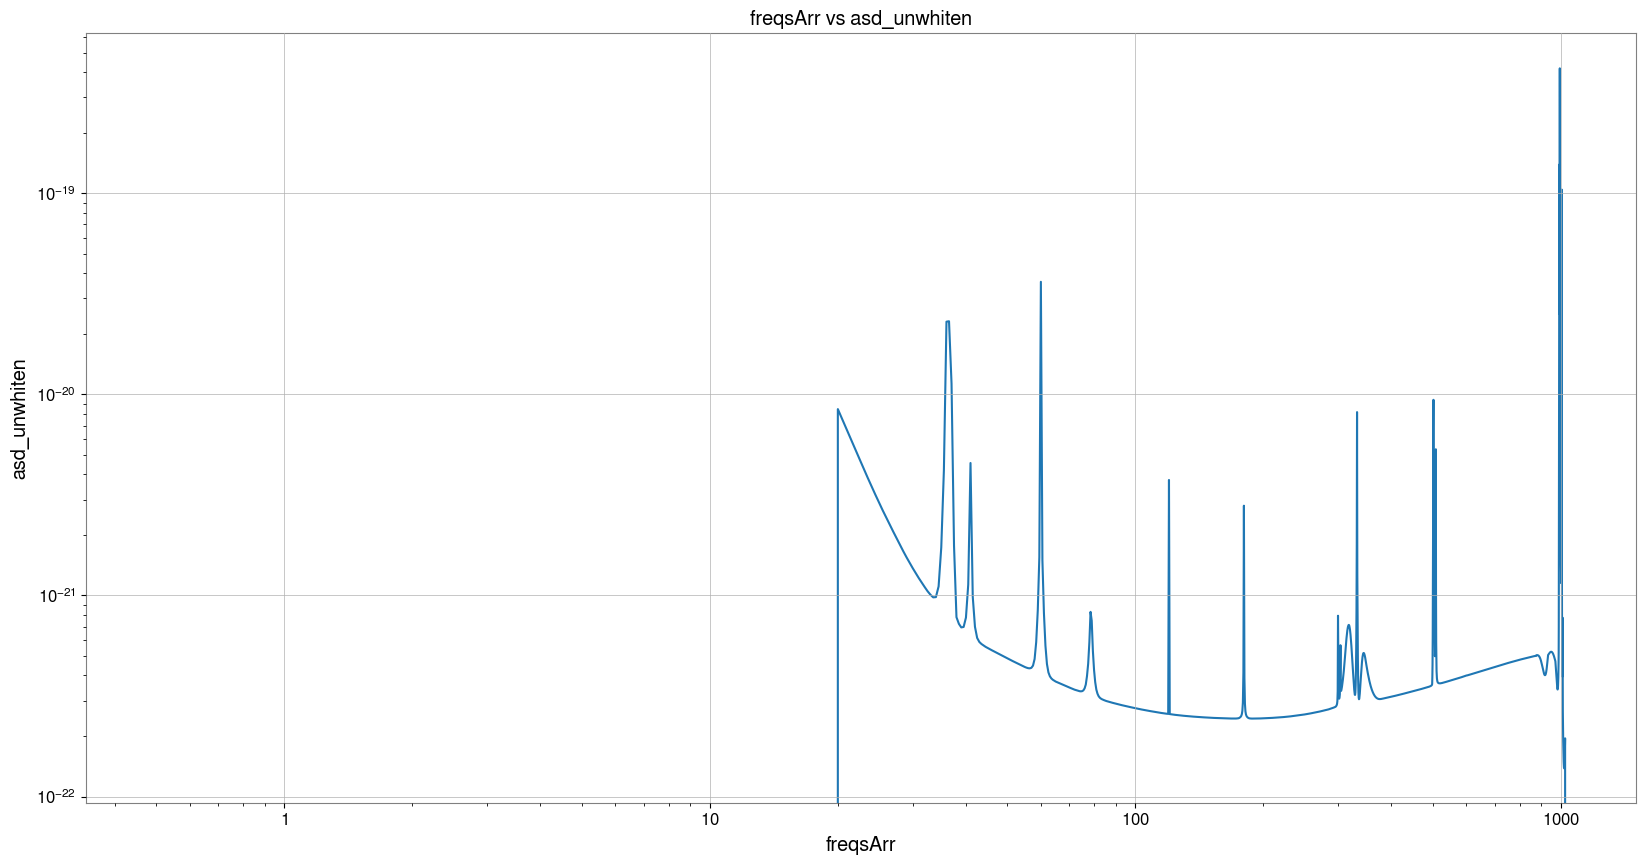

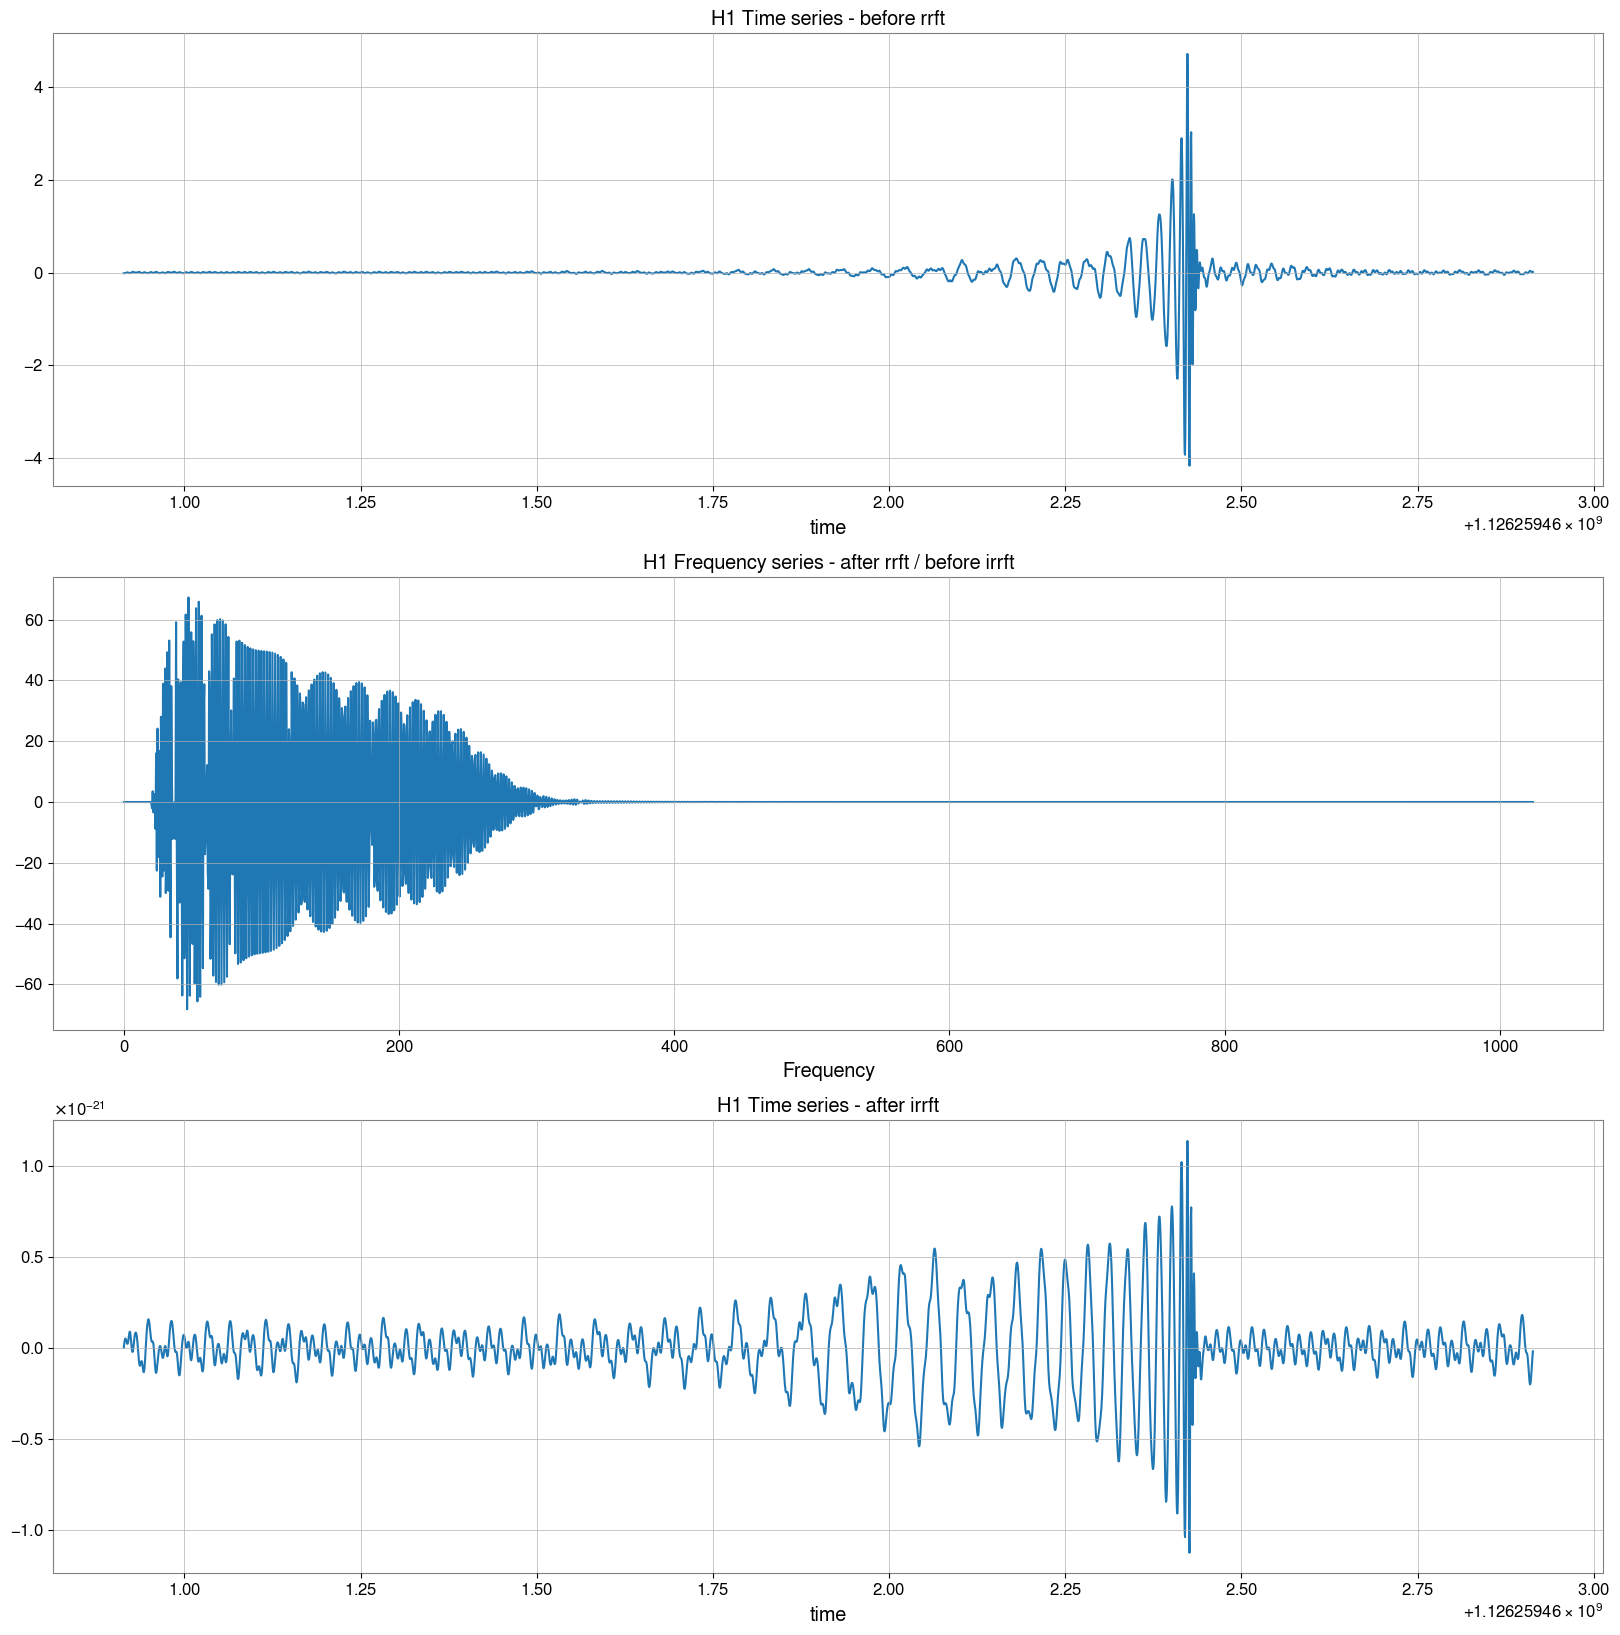

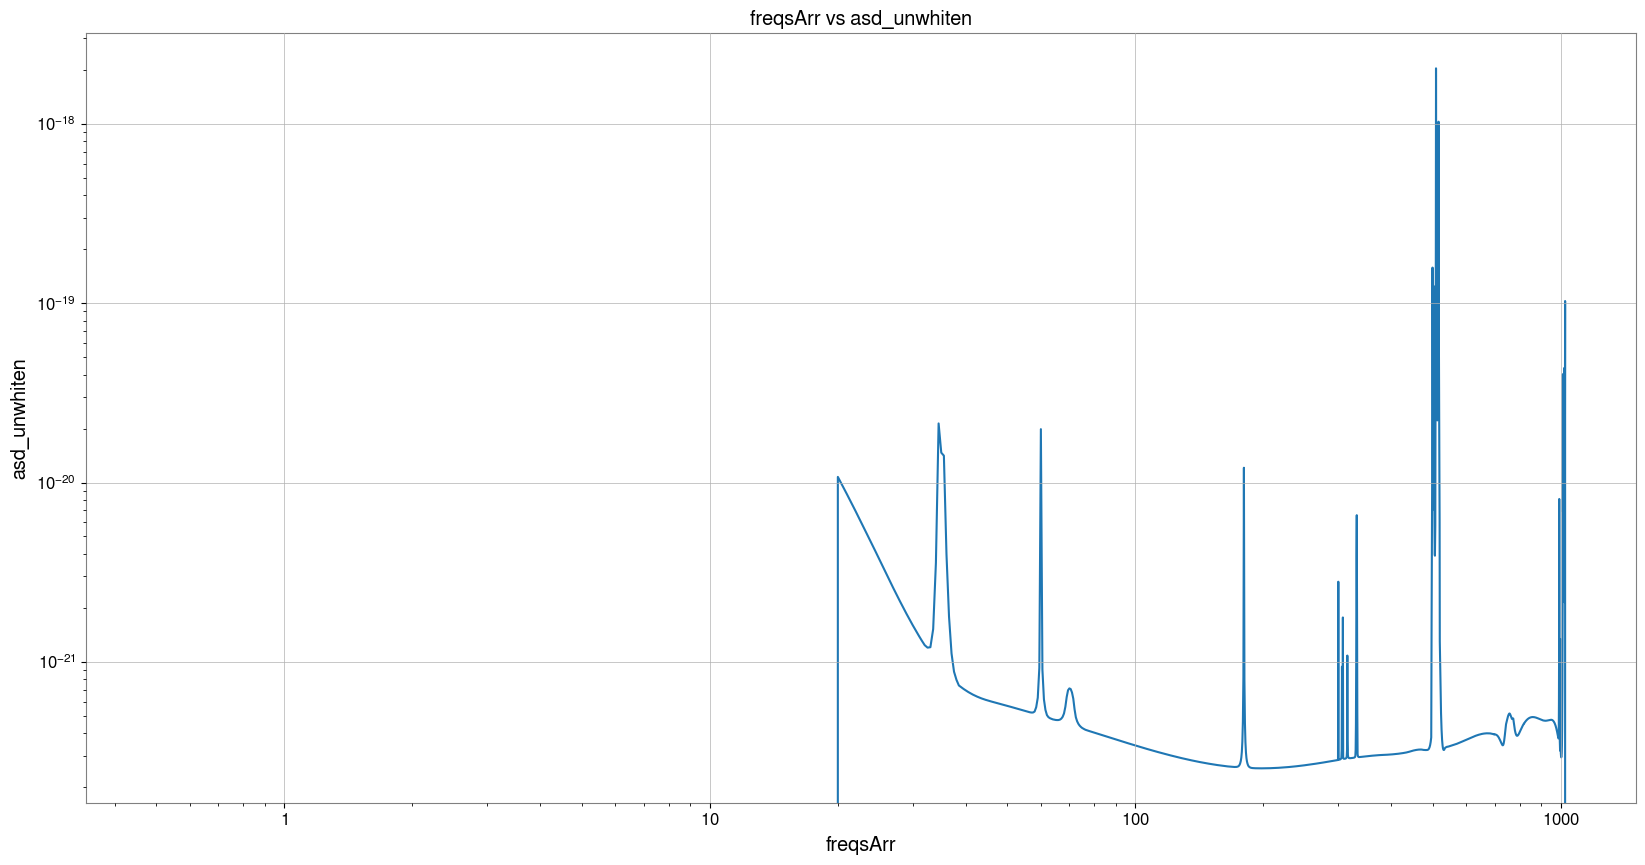

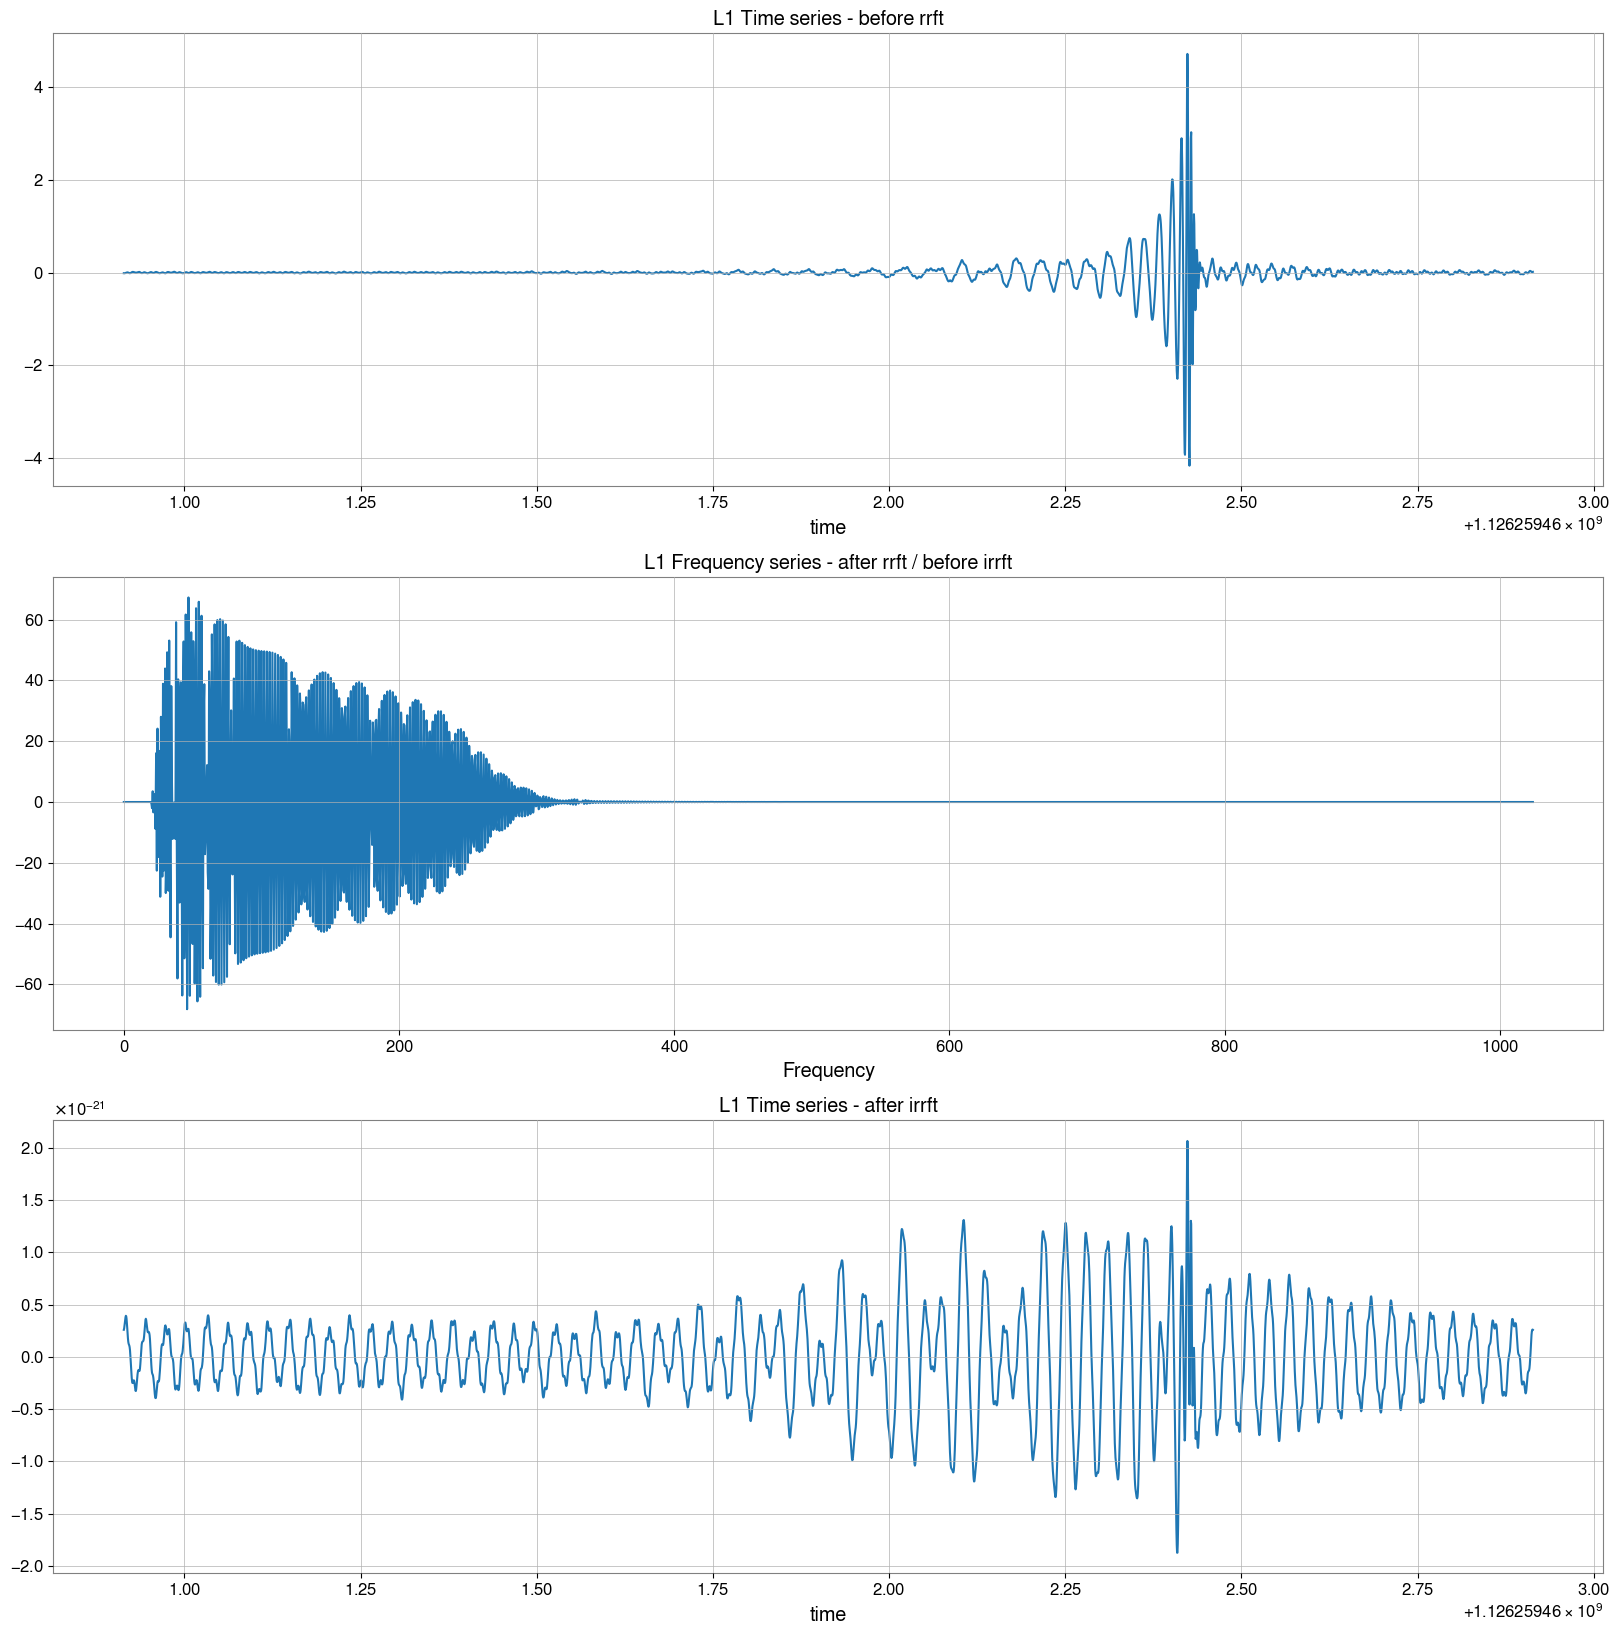

In [125]:
#unwhitening the tmp_data using the above function
uw_tmp_sig_h1 = unwhitening(temp_h1_1, psd_data_h1, time_h1, 'H1')
uw_tmp_sig_l1 = unwhitening(temp_l1_1, psd_data_l1, time_l1, 'L1')

Step 2: set whiten=False in get_td_waveform and get the datat<br>

In [126]:
det_strain_h1_uw = gen_td_waveform(samples_1, deltaT, delta_f, flow, approx, \
                f_ref = fref, det='H1', ind=0, asd_whiten = asd_whiten, \
                whiten=False, strain_end_time = strain_end_time, millilens_type=None, LIVFlag=False)

Step:3 Overlap plotting the gen_td_waveform over the template data (both unwhitened)

(1126259461.9140625, 1126259462.7135742)

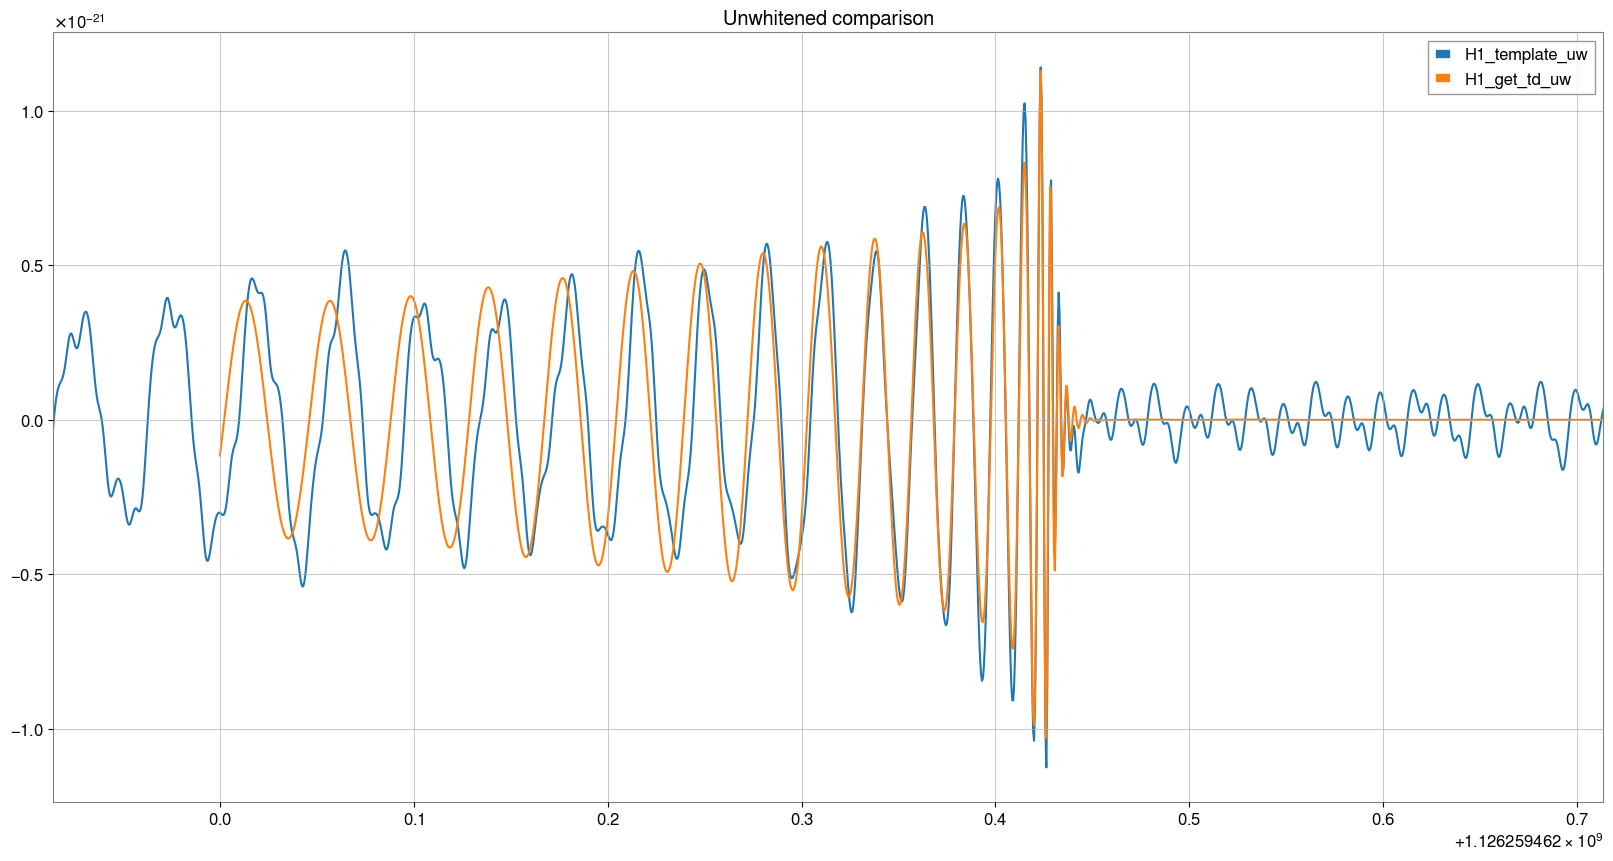

In [127]:
plt.figure(figsize=(20,10))
plt.plot(time_h1, uw_tmp_sig_h1, label = 'H1_template_uw')
plt.plot(det_strain_h1_uw, label='H1_get_td_uw')
plt.title('Unwhitened comparison')
plt.legend()
plt.xlim(time_h1.min()+1,time_h1.max()-0.2)

Getting the Antenna Parameter of H1 and L1 detectors

In [128]:
#setting the geocent_time
geocent_time = samples['geocent_time'][0]

#setting up detectors H1 and L1
ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])
h1 = ifos[0]
l1 = ifos[1]
ra, dec, psi = samples_400['ra'], samples_400['dec'] , samples_400['psi']

#Getting the antenna parameter values
F_plus_h1 = []
for i in range(len(ra)):
    F_plus_h1.append(h1.antenna_response(ra[i], dec[i], geocent_time, psi[i], 'plus'))
F_plus_h1 = np.array(F_plus_h1)

F_plus_l1 = []
for i in range(len(ra)):
    F_plus_l1.append(l1.antenna_response(ra[i], dec[i], geocent_time, psi[i], 'plus'))
F_plus_l1 = np.array(F_plus_l1)

F_cross_h1 = []
for i in range(len(ra)):
    F_cross_h1.append(h1.antenna_response(ra[i], dec[i], geocent_time, psi[i], 'cross'))
F_cross_h1 = np.array(F_cross_h1)

F_cross_l1 = []
for i in range(len(ra)):
    F_cross_l1.append(l1.antenna_response(ra[i], dec[i], geocent_time, psi[i], 'cross'))
F_cross_l1 = np.array(F_cross_l1)

To get the values of $h_+ and h_\times$, we use the following formula <br>

$h_H(t) = ({F_+}_H * h_+) + ({F_\times}_H * h_\times)$ for H1 detector <br>
$h_L(t) = ({F_+}_L * h_+) + ({F_\times}_L * h_\times)$ for L1 detector

Solving two equation for two unknowns $h_+$ and $h_\times$

Loading the rec_signal files and unwhitening them

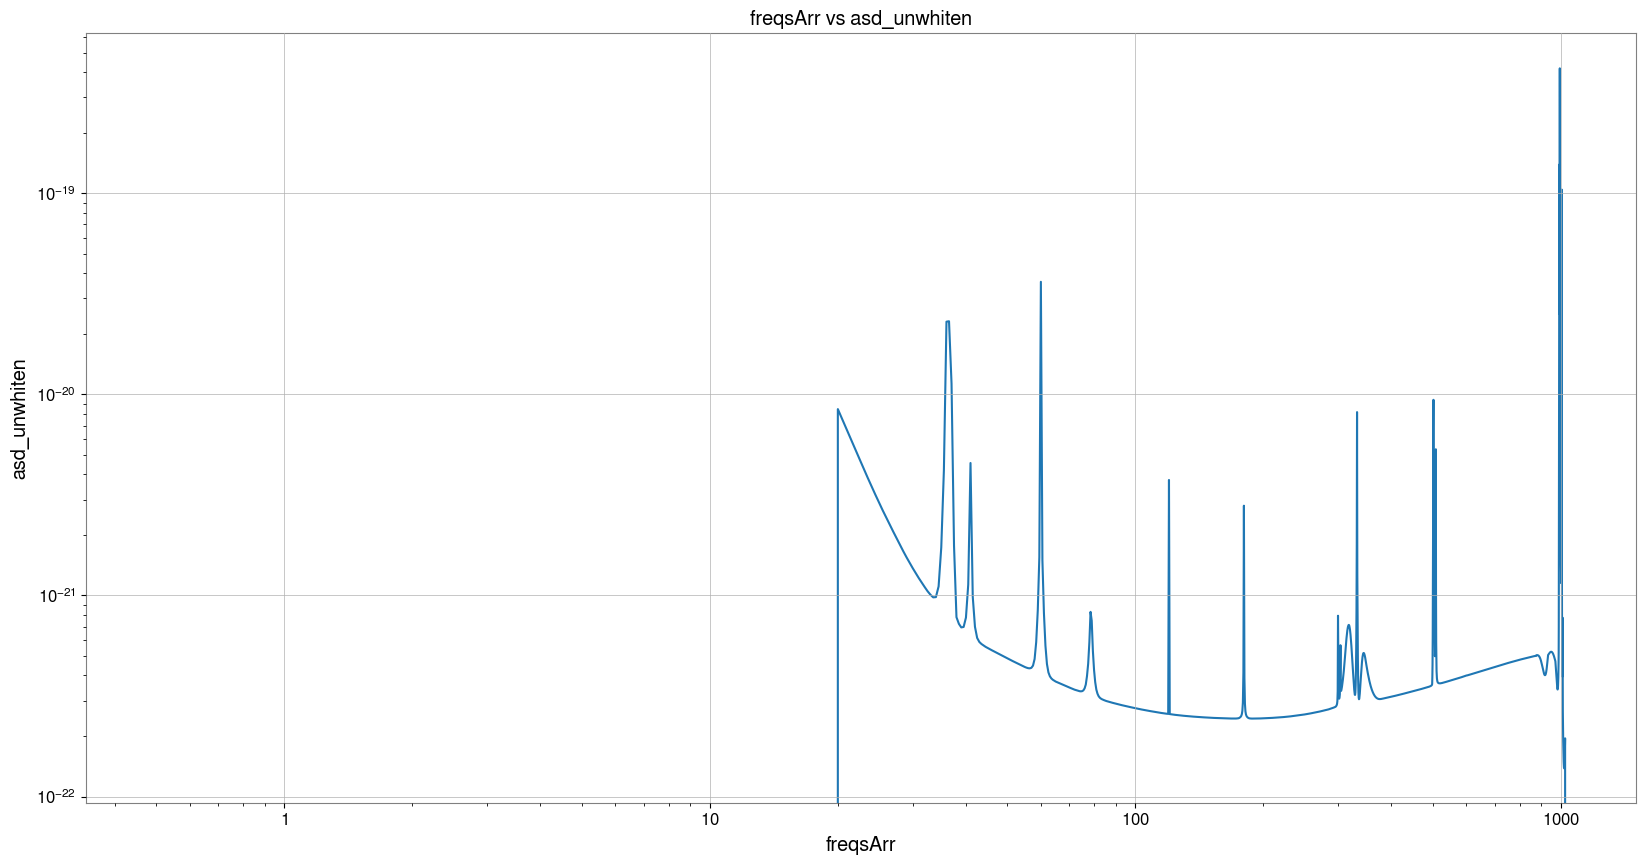

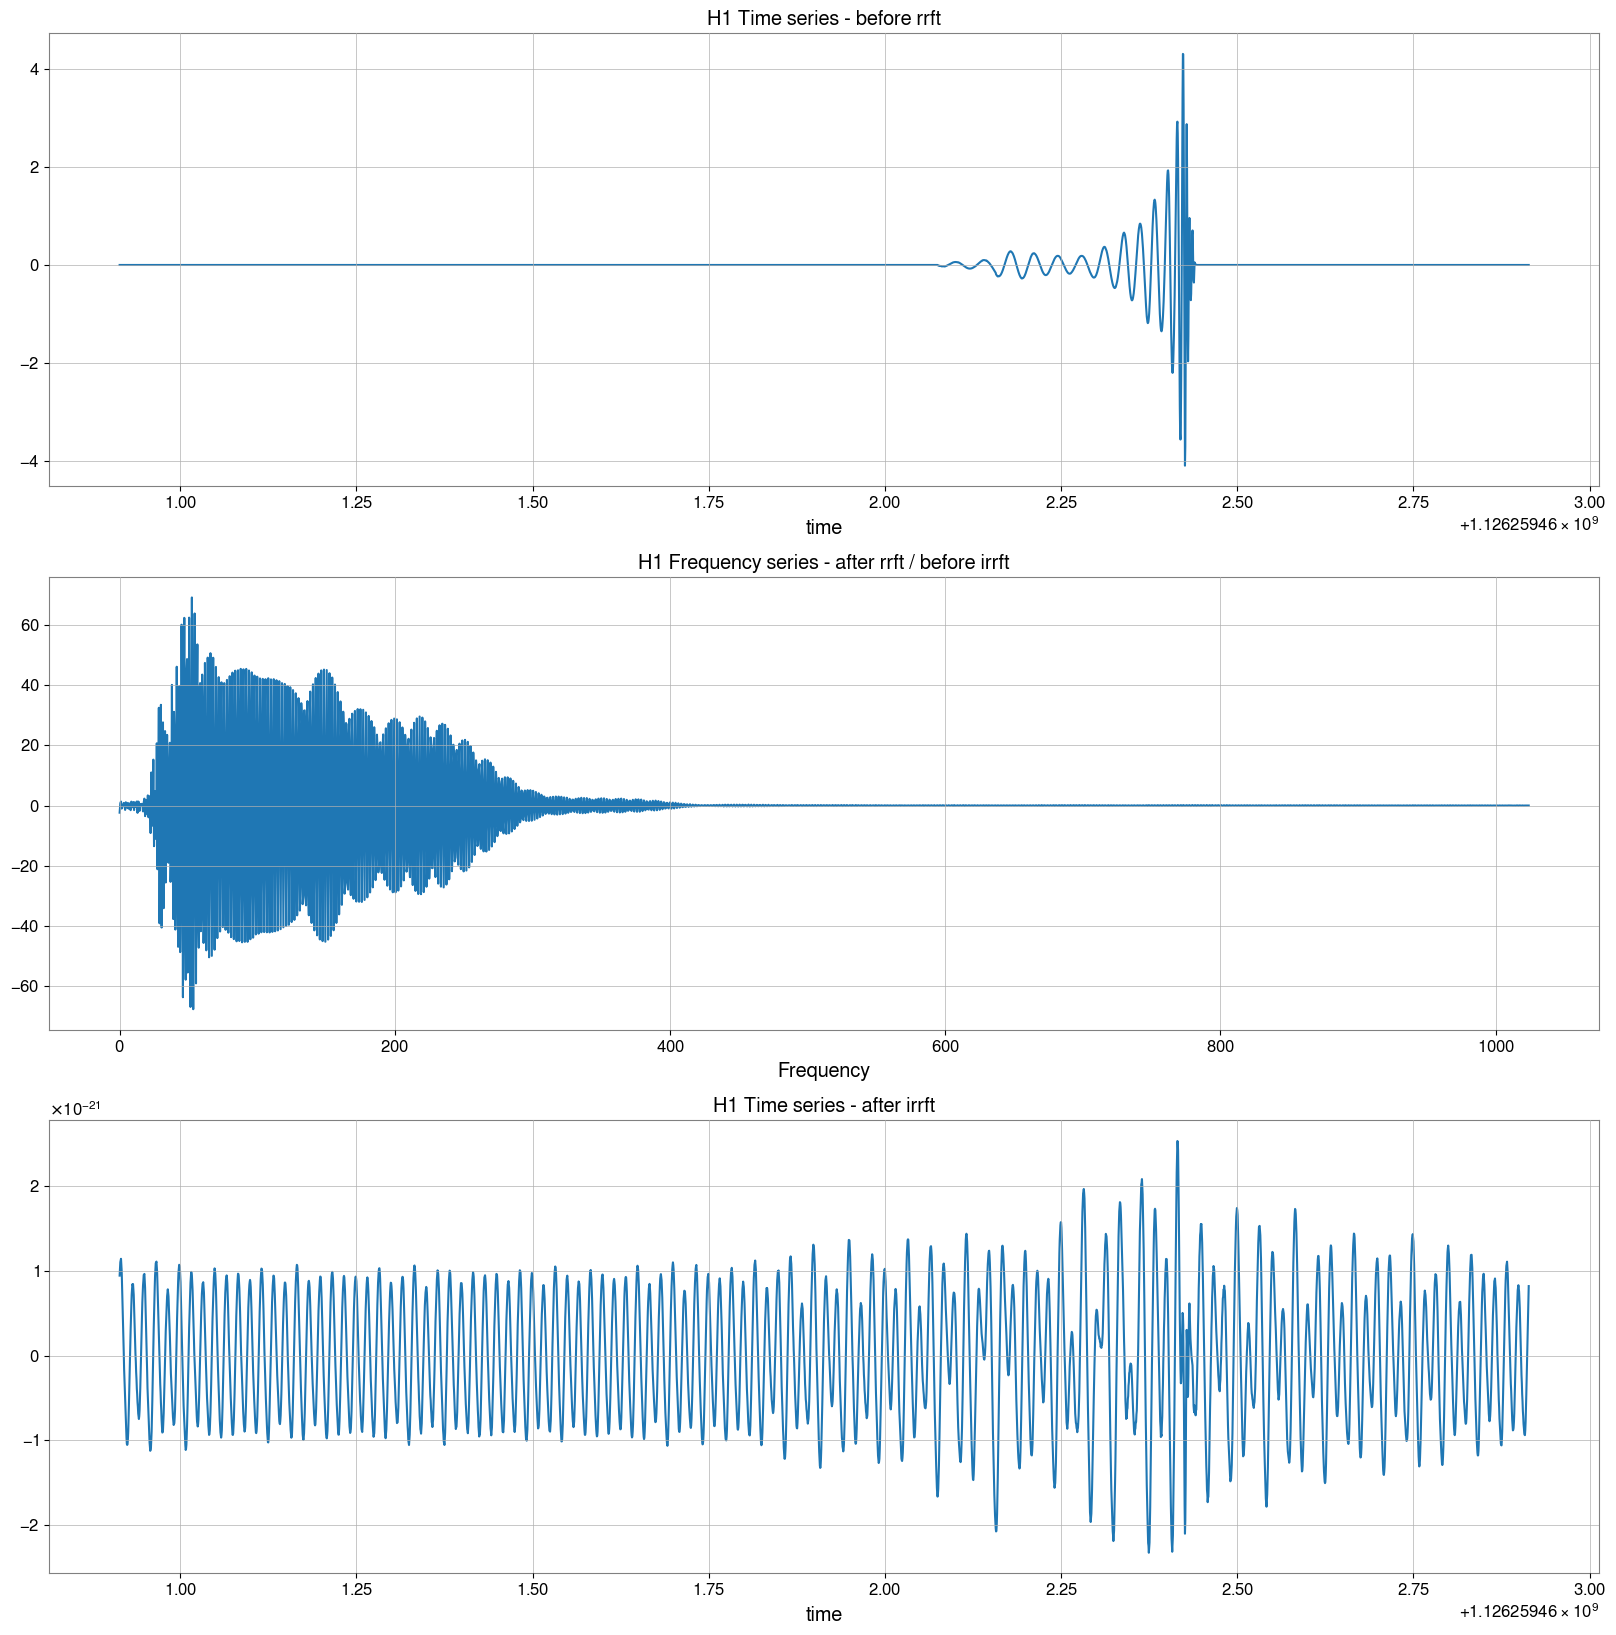

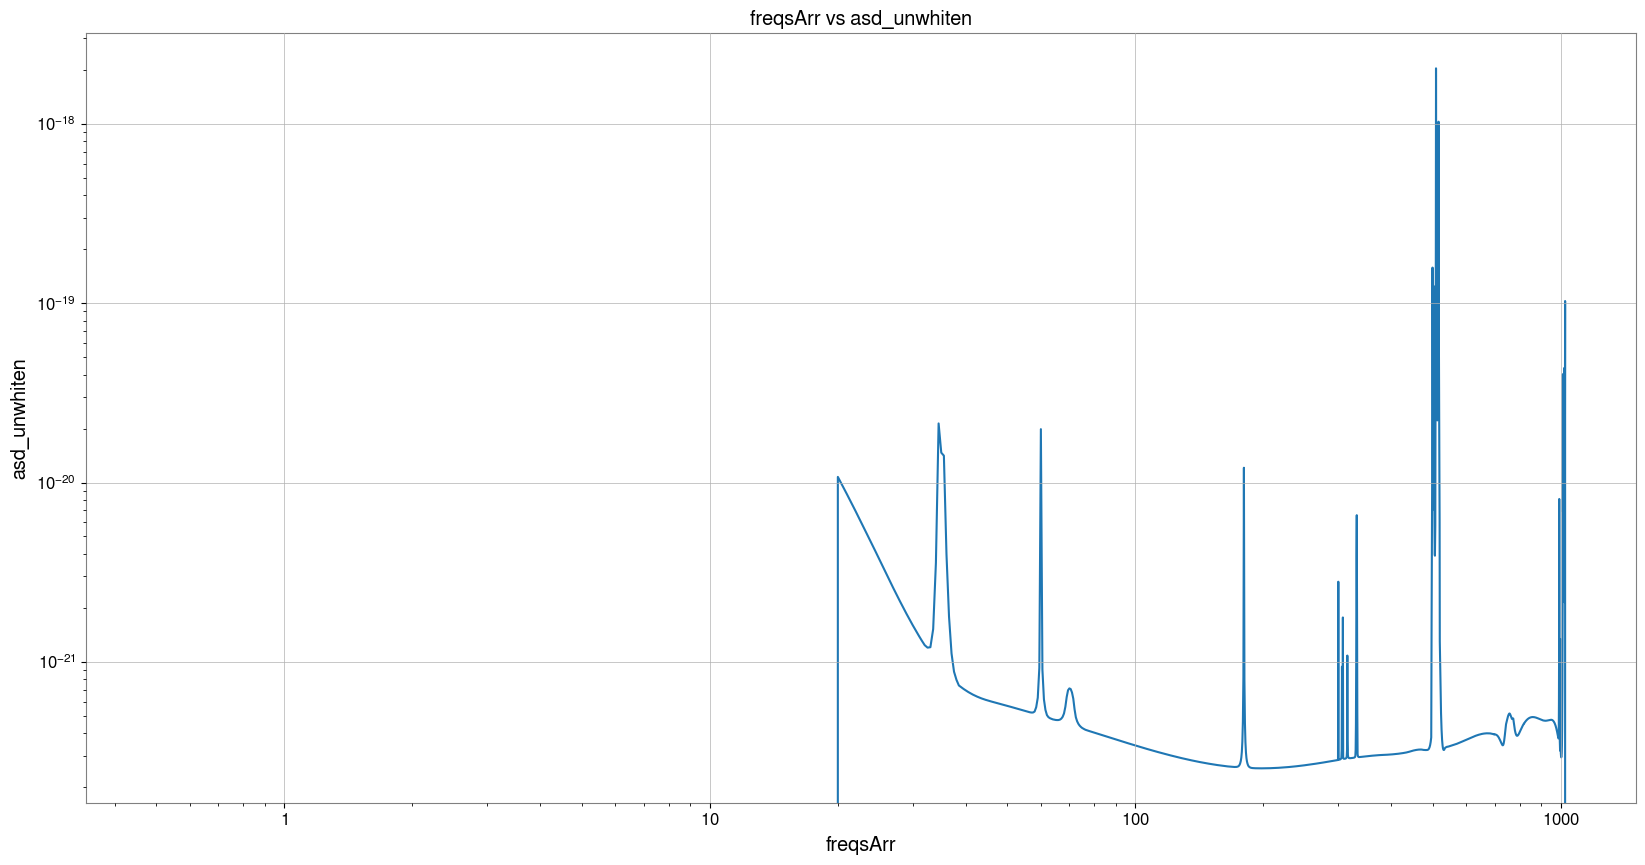

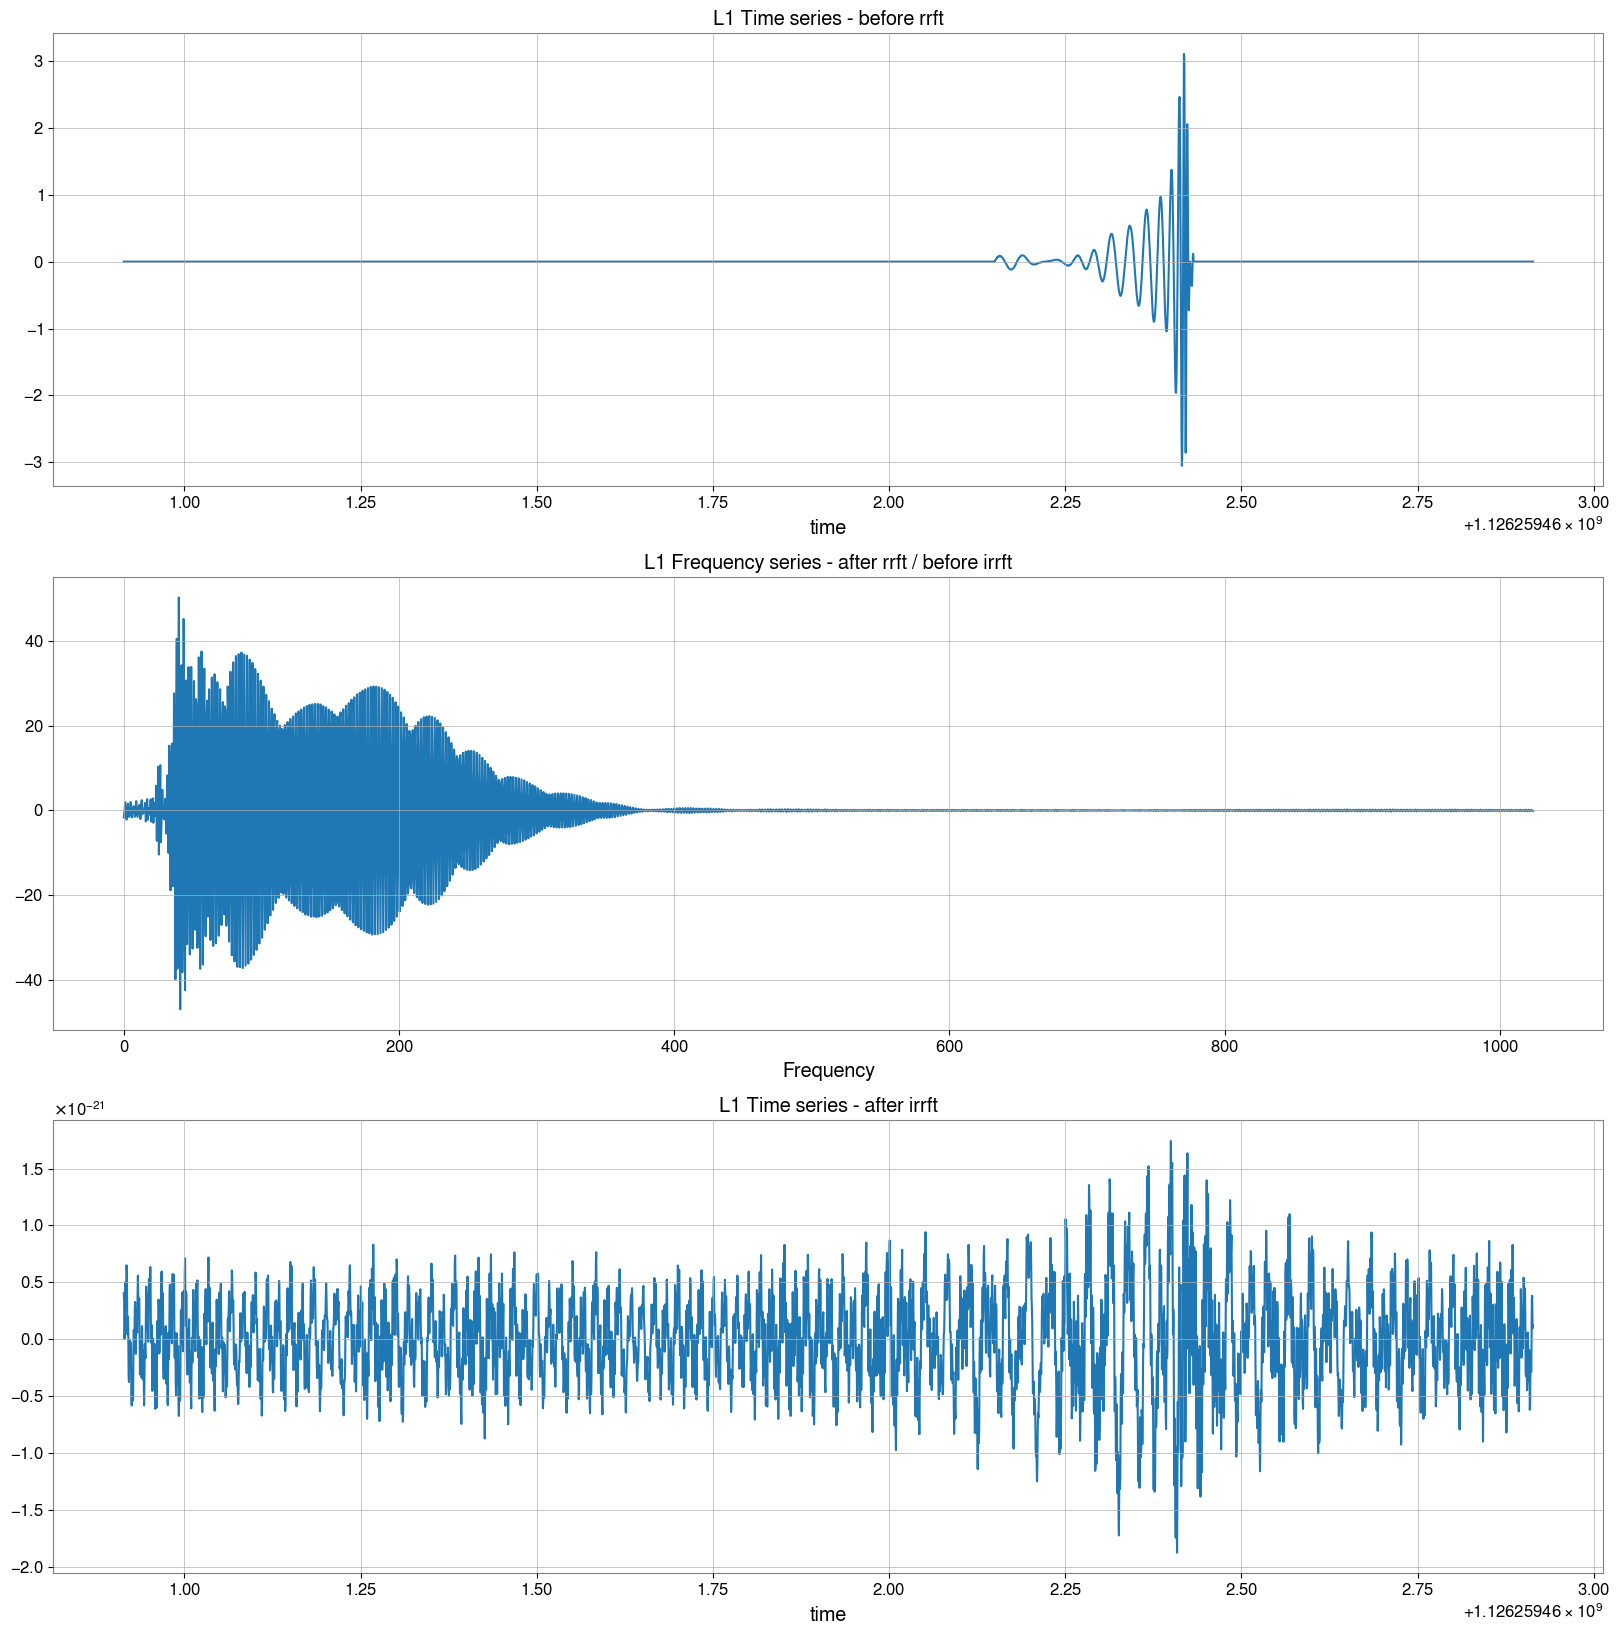

In [129]:
rec_sig_h1 = np.load('Test/IMRPhenomXHM/onsource_overlap/rec_data_H1_0_400.npy')
rec_sig_l1 = np.load('Test/IMRPhenomXHM/onsource_overlap/rec_data_L1_0_400.npy')

uw_rec_sig_h1 = unwhitening(rec_sig_h1[0], psd_data_h1, time_h1, 'H1')
uw_rec_sig_l1 = unwhitening(rec_sig_l1[0], psd_data_l1, time_l1, 'L1')

In [130]:
#making hplus and hcross variables
hplus, hcross = symbols('hplus hcross')
import time
s_t = time.time()
#calculating hplus and hcross timeseries
h_plus=[]
h_cross=[]
for j in range(len(uw_tmp_sig_h1)):
    eq1 = Eq(uw_tmp_sig_h1[j], F_plus_h1[0]*hplus - F_cross_h1[0]*hcross)
    eq2 = Eq(uw_tmp_sig_l1[j], F_plus_l1[0]*hplus - F_cross_l1[0]*hcross)
    sol = solve((eq1,eq2), (hplus, hcross))
    h_cross.append(sol[hcross])
    h_plus.append(sol[hplus])
t_t = time.time() - s_t



156.51061964035034


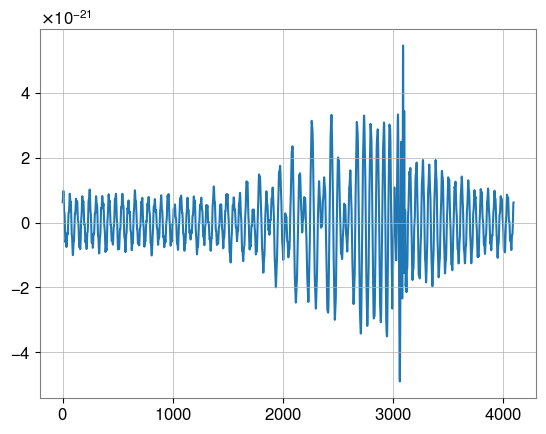

In [134]:
plt.plot(h_plus)
print(t_t)

-1.56658944052190e-21
-1.72501366826483e-21
-1.93962346822966e-21
-2.17240000941364e-21
-2.38325307333568e-21
-2.53971614486643e-21
-2.60504895514308e-21
-2.54604464985832e-21
-2.36407556569014e-21
-2.09383789141092e-21
-1.78020769062306e-21
-1.46905336349525e-21
-1.21674399287397e-21
-1.07032400779439e-21
-1.03313942204046e-21
-1.05710518819142e-21
-1.07496476730280e-21
-1.02407969047652e-21
-8.55957507922151e-22
-5.48524109789478e-22
-1.27199483074810e-22
3.44048202165969e-22
7.95282116093097e-22
1.17509371098873e-21
1.44539894090032e-21
1.58069221192764e-21
1.58094598509622e-21
1.48173003745401e-21
1.33855619800758e-21
1.20842345316207e-21
1.13929593451958e-21
1.16095922179515e-21
1.26399337350479e-21
1.39535987366041e-21
1.48654767427842e-21
1.49509264700935e-21
1.41703365251005e-21
1.27441412573205e-21
1.10335629290587e-21
9.50373281535364e-22
8.56493727637391e-22
8.37712951068123e-22
8.86410171821353e-22
9.88703920178935e-22
1.12203721755424e-21
1.23628622329825e-21
1.26169137757

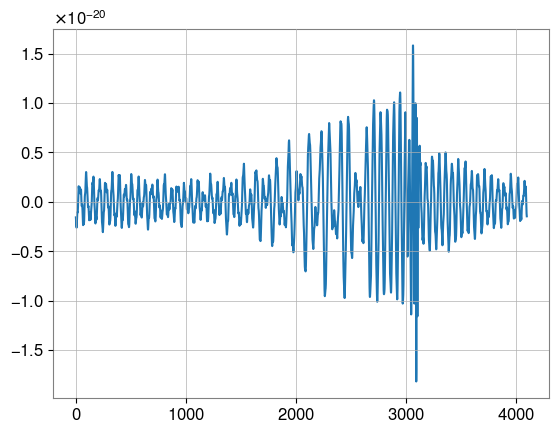

In [133]:
plt.plot(h_cross)
for i in h_cross:
    print(i)